In [1]:
# !pip install sentence-transformers wordcloud scikit-learn matplotlib seaborn pandas numpy

In [2]:
from tqdm import tqdm
tqdm.notebook = tqdm


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import joblib
import os

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")


In [4]:
df = pd.read_csv("/content/drive/MyDrive/OLD DATA/RESUME_SEG/Resume_Dataset.csv")
print(f"Initial dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Initial dataset shape: (962, 1)
Columns: ['Resume']


In [5]:
df.head()

Resume
0  Skills * Programming Languages: Python (pandas...
1  Education Details \r\nMay 2013 to May 2017 B.E...
2  Areas of Interest Deep Learning, Control Syste...
3  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Education Details \r\n MCA   YMCAUST,  Faridab...

In [6]:
# Clean text function
def clean_resume_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s+#.-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Identify text column
resume_column = None
for col in df.columns:
    if 'resume' in col.lower() or 'text' in col.lower():
        resume_column = col
        break
if resume_column is None:
    resume_column = df.columns[0]

print(f"Using column '{resume_column}' as resume text")

# Apply cleaning
df['cleaned_resume'] = df[resume_column].apply(clean_resume_text)
df = df[df['cleaned_resume'].str.len() > 50]  # remove very short texts

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Sample cleaned text:\n{df['cleaned_resume'].iloc[0][:300]}...")


Using column 'Resume' as resume text
Dataset shape after cleaning: (962, 2)
Sample cleaned text:
skills programming languages python pandas numpy scipy scikit-learn matplotlib sql java javascript jquery. machine learning regression svm na ve bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality re...


In [7]:
df['word_count'] = df['cleaned_resume'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_resume'].apply(len)
df['unique_words'] = df['cleaned_resume'].apply(lambda x: len(set(x.split())))

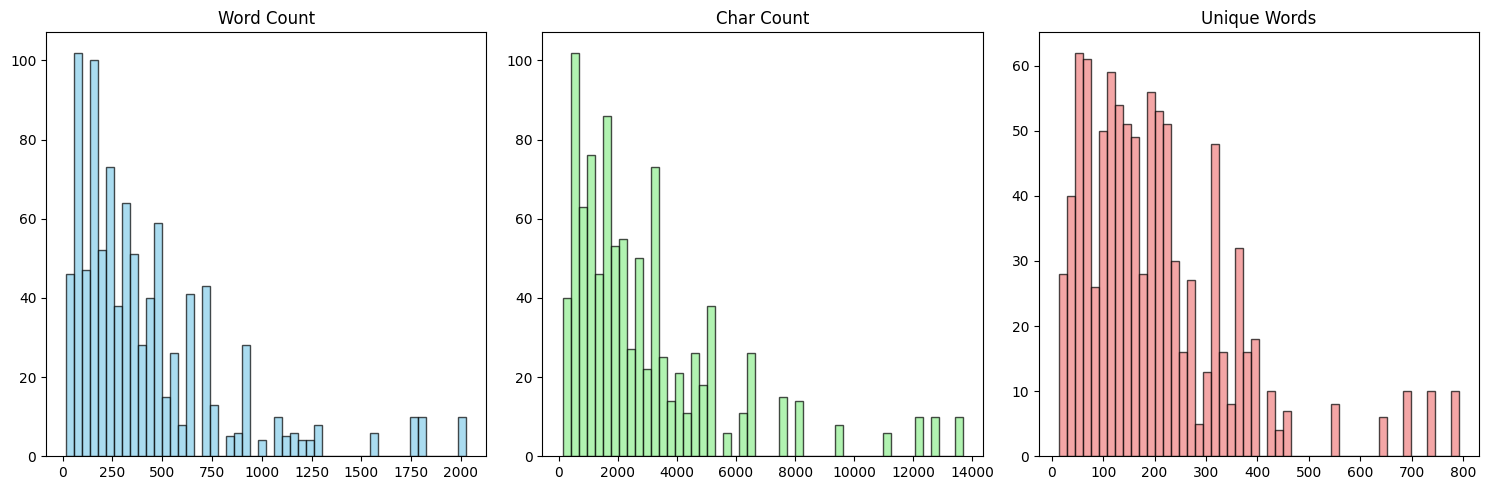

In [8]:
# Basic distributions
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(df['word_count'],bins=50,alpha=0.7,color='skyblue',edgecolor='black')
plt.title("Word Count")

plt.subplot(1, 3, 2)
plt.hist(df['char_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Char Count')

plt.subplot(1, 3, 3)
plt.hist(df['unique_words'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Unique Words')
plt.tight_layout()
plt.show()

In [9]:
print(f"Average word count: {df['word_count'].mean():.2f}")
print(f"Average character count: {df['char_count'].mean():.2f}")
print(f"Average unique words: {df['unique_words'].mean():.2f}")

Average word count: 422.72
Average character count: 2925.55
Average unique words: 203.49


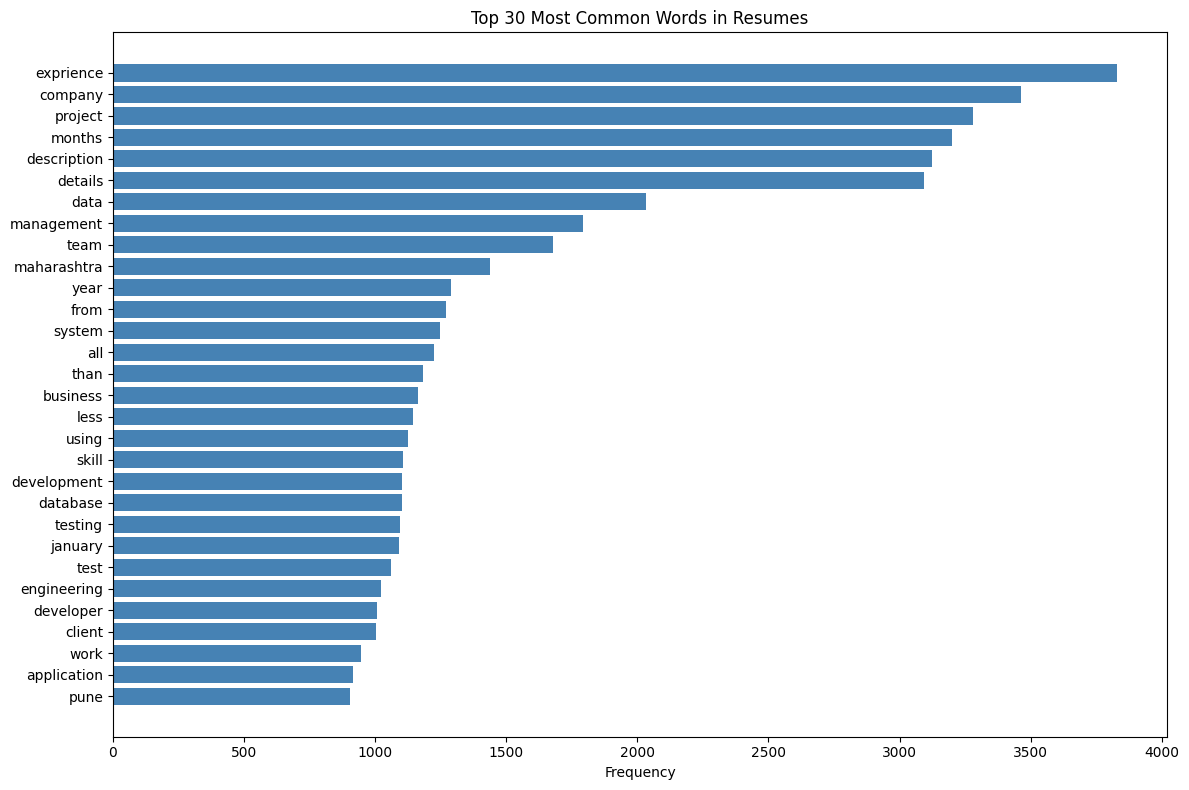

In [10]:
common_stop_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'shall', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'their'}

all_words = ' '.join(df['cleaned_resume']).split()
word_freq = Counter(all_words)
filtered_words = {word: count for word, count in word_freq.items()
                  if word not in common_stop_words and len(word) > 2}
most_common = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)[:30]

plt.figure(figsize=(12, 8))
words, counts = zip(*most_common)
plt.barh(range(len(words)), counts, color='steelblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Top 30 Most Common Words in Resumes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [11]:
# Load transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Generating BERT embeddings for resumes...")
embeddings = model.encode(df['cleaned_resume'].tolist(),
                          batch_size=100, show_progress_bar=False)

X_embeddings = np.array(embeddings)
print(f"Embeddings shape: {X_embeddings.shape}")


Generating BERT embeddings for resumes...
Embeddings shape: (962, 384)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embeddings)

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA shape: {X_pca.shape}")
print(f"Explained variance retained: {pca.explained_variance_ratio_.sum():.2%}")

import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=50, random_state=42)
X_umap = umap_model.fit_transform(X_pca)
print(f"UMAP shape: {X_umap.shape}")


PCA shape: (962, 100)
Explained variance retained: 95.98%
UMAP shape: (962, 50)


Testing different number of clusters...
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Testing k=11...
Testing k=12...
Testing k=13...
Testing k=14...
Testing k=15...
Testing k=16...
Testing k=17...
Testing k=18...
Testing k=19...
Testing k=20...
Testing k=21...
Testing k=22...
Testing k=23...
Testing k=24...
Testing k=25...


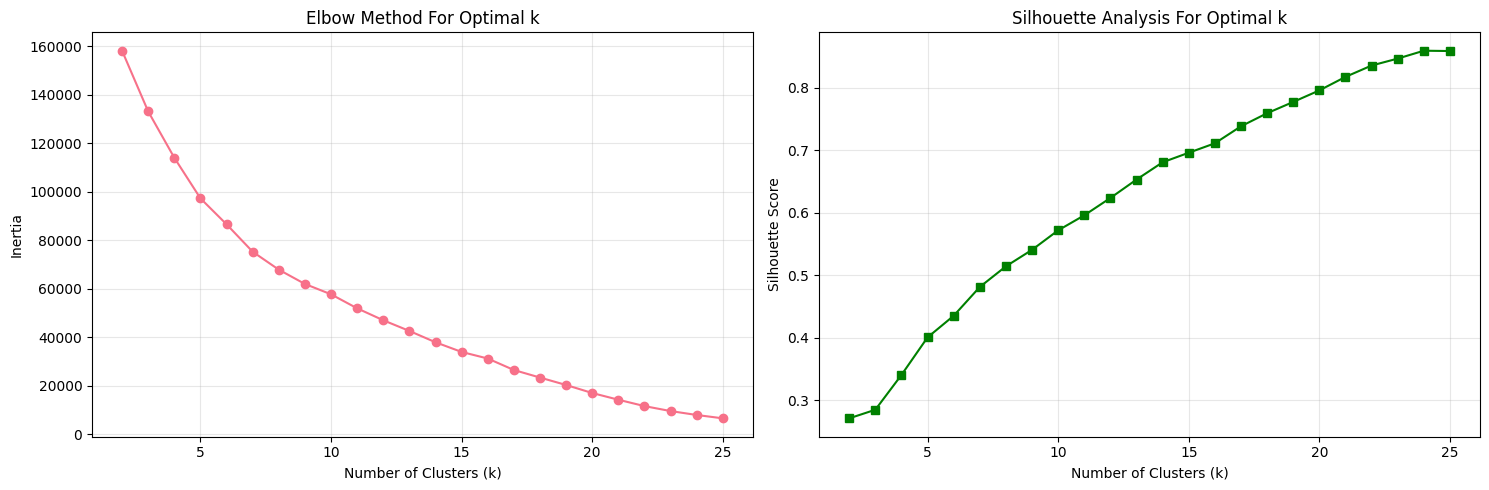

Optimal clusters: 24
Best silhouette score: 0.8593


In [13]:
k_range = range(2, 26)
inertias = []
silhouette_scores = []

print("Testing different number of clusters...")
for k in k_range:
    print(f"Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    cluster_labels = kmeans.fit_predict(X_umap)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_umap, cluster_labels))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='s', color='green')
plt.title('Silhouette Analysis For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal clusters: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")


In [14]:
print(f"Applying final KMeans clustering with k={optimal_k}...")
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
final_labels = final_kmeans.fit_predict(X_umap)
df['cluster'] = final_labels

print("Cluster distribution:")
print(df['cluster'].value_counts().sort_index())


Applying final KMeans clustering with k=24...
Cluster distribution:
cluster
0      18
1     130
2     131
3     111
4      37
5      97
6      31
7      74
8      36
9      70
10     17
11     20
12     18
13     24
14     24
15     17
16     20
17     15
18     17
19     10
20     10
21     18
22      6
23     11
Name: count, dtype: int64


In [15]:
hdb = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')
cluster_labels_hdbscan = hdb.fit_predict(X_umap)
valid_points = cluster_labels_hdbscan != -1
sil_score = silhouette_score(X_umap[valid_points], cluster_labels_hdbscan[valid_points])
print(f"Silhouette score (HDBSCAN): {sil_score:.4f}")

# Cluster summary
labels = hdb.labels_
unique_clusters = np.unique(labels)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

print(f"Number of clusters found: {n_clusters}")
print(f"Noise points: {sum(labels == -1)}")


Silhouette score (HDBSCAN): 0.8107
Number of clusters found: 18
Noise points: 238


# Choosing K Means

In [16]:
# This is unchanged: Use your previous 'analyze_cluster_content' and 'auto_name_cluster_unique' code
used_names = set()

def analyze_cluster_content(cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    cluster_text = ' '.join(cluster_data['cleaned_resume'])
    words = cluster_text.split()
    word_freq = Counter(words)
    filtered_words = {word: count for word, count in word_freq.items()
                      if word not in common_stop_words and len(word) > 2}
    top_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)[:15]
    return {
        'size': len(cluster_data),
        'top_words': top_words,
        'avg_word_count': cluster_data['word_count'].mean(),
        'sample_text': cluster_data.iloc[0]['cleaned_resume'][:200] if len(cluster_data) > 0 else ""
    }

def auto_name_cluster_unique(cluster_id):
    analysis = analyze_cluster_content(cluster_id)
    top_words = [word for word, count in analysis['top_words']]

    # Based on your provided categories, here's the complete mapping
    categories = {
        'Data Scientists': ['data', 'science', 'analytics', 'machine learning', 'statistics', 'research', 'modeling'],
        'Java Developers': ['java', 'spring', 'hibernate', 'jsp', 'servlet', 'maven', 'struts'],
        'Python Developers': ['python', 'django', 'flask', 'pandas', 'numpy', 'scipy', 'pytorch'],
        'DevOps Engineers': ['devops', 'cloud', 'aws', 'azure', 'docker', 'kubernetes', 'jenkins', 'ansible'],
        'Frontend Developers': ['web', 'designing', 'html', 'css', 'javascript', 'react', 'angular', 'vue'],
        'QA Engineers': ['testing', 'automation', 'selenium', 'qa', 'quality', 'junit', 'testng'],
        'Database Administrators': ['database', 'sql', 'mysql', 'oracle', 'postgresql', 'dba', 'nosql'],
        'Data Engineers': ['hadoop', 'spark', 'hive', 'pig', 'kafka', 'airflow', 'big data'],
        'ETL Developers': ['etl', 'extract', 'transform', 'load', 'informatica', 'talend', 'ssis'],
        '.NET Developers': ['dotnet', 'net', 'c#', 'asp', 'mvc', 'wcf', 'entity framework'],
        'Business Analysts': ['business', 'analyst', 'requirements', 'stakeholder', 'process', 'analysis'],
        'SAP Developers': ['sap', 'abap', 'hana', 'fiori', 'bw', 'pi', 'successfactors'],
        'Network Security Engineers': ['network', 'security', 'firewall', 'cisco', 'juniper', 'cybersecurity'],
        'Operations Managers': ['operations', 'manager', 'process', 'efficiency', 'workflow', 'optimization'],
        'HR Professionals': ['hr', 'human resources', 'recruitment', 'talent', 'hiring', 'payroll'],
        'Sales Representatives': ['sales', 'customer', 'client', 'revenue', 'target', 'crm', 'business development'],
        'Project Managers': ['project', 'pmo', 'management', 'scrum', 'agile', 'coordination', 'delivery'],
        'Mechanical Engineers': ['mechanical', 'engineering', 'design', 'manufacturing', 'cad', 'solidworks'],
        'Civil Engineers': ['civil', 'construction', 'structural', 'autocad', 'project planning'],
        'Electrical Engineers': ['electrical', 'electronics', 'circuit', 'power', 'automation', 'plc'],
        'Blockchain Specialists': ['blockchain', 'ethereum', 'smart contracts', 'cryptocurrency', 'web3'],
        'Legal Professionals': ['advocate', 'legal', 'law', 'litigation', 'compliance', 'contracts'],
        'Creative Professionals': ['arts', 'design', 'creative', 'graphic', 'multimedia', 'photography'],
        'Health & Fitness Specialists': ['health', 'fitness', 'wellness', 'nutrition', 'exercise', 'training'],
        'Technical Consultants': ['consultant', 'advisory', 'technical', 'solutions', 'implementation']
    }

    scores = {}
    for category, keywords in categories.items():
        if category not in used_names:  # Only consider unused names
            score = sum(1 for keyword in keywords if any(keyword in word for word in top_words))
            scores[category] = score

    # Get best unused match
    if scores and max(scores.values()) > 0:
        best_category = max(scores, key=scores.get)
        used_names.add(best_category)
        return best_category
    else:
        # Create unique fallback names
        fallback_names = [
            "Tech Professionals", "IT Specialists", "Business Professionals",
            "Creative Professionals", "Engineering Specialists", "Support Professionals",
            "Administrative Staff", "Technical Consultants", "Industry Specialists",
            "Domain Experts", "Service Professionals", "Operational Staff"
        ]

        # Use fallback that hasn't been used
        for name in fallback_names:
            unique_name = f"{name} {cluster_id}"
            if unique_name not in used_names:
                used_names.add(unique_name)
                return unique_name

        # Final fallback
        return f"Professional Group {cluster_id}"

cluster_names = {}
print("Generating unique cluster names based on your categories...")
print("=" * 60)

for cluster_id in range(optimal_k):
    name = auto_name_cluster_unique(cluster_id)
    cluster_names[cluster_id] = name
    analysis = analyze_cluster_content(cluster_id)
    print(f"Cluster {cluster_id:2d}: {name:<30} ({analysis['size']:3d} resumes)")
    print(f"         Top words: {[word for word, count in analysis['top_words'][:5]]}")
    print()

# Add unique cluster names to dataframe
df['cluster_name'] = df['cluster'].map(cluster_names)

print("All clusters now have unique names based on your categories!")
print(f"\nFinal Cluster Summary:")
for cluster_id in range(optimal_k):
    count = sum(df['cluster'] == cluster_id)
    percentage = count / len(df) * 100
    print(f"  {cluster_id:2d}. {cluster_names[cluster_id]:<30}: {count:3d} resumes ({percentage:4.1f}%)")


Generating unique cluster names based on your categories...
Cluster  0: Java Developers                ( 18 resumes)
         Top words: ['java', 'developer', 'development', 'exprience', 'details']

Cluster  1: Sales Representatives          (130 resumes)
         Top words: ['project', 'management', 'exprience', 'months', 'company']

Cluster  2: Operations Managers            (131 resumes)
         Top words: ['company', 'team', 'operations', 'details', 'description']

Cluster  3: Frontend Developers            (111 resumes)
         Top words: ['exprience', 'months', 'java', 'details', 'company']

Cluster  4: .NET Developers                ( 37 resumes)
         Top words: ['details', 'company', 'description', 'university', 'maharashtra']

Cluster  5: Database Administrators        ( 97 resumes)
         Top words: ['exprience', 'details', 'data', 'months', 'description']

Cluster  6: Business Analysts              ( 31 resumes)
         Top words: ['test', 'testing', 'company', 'bus

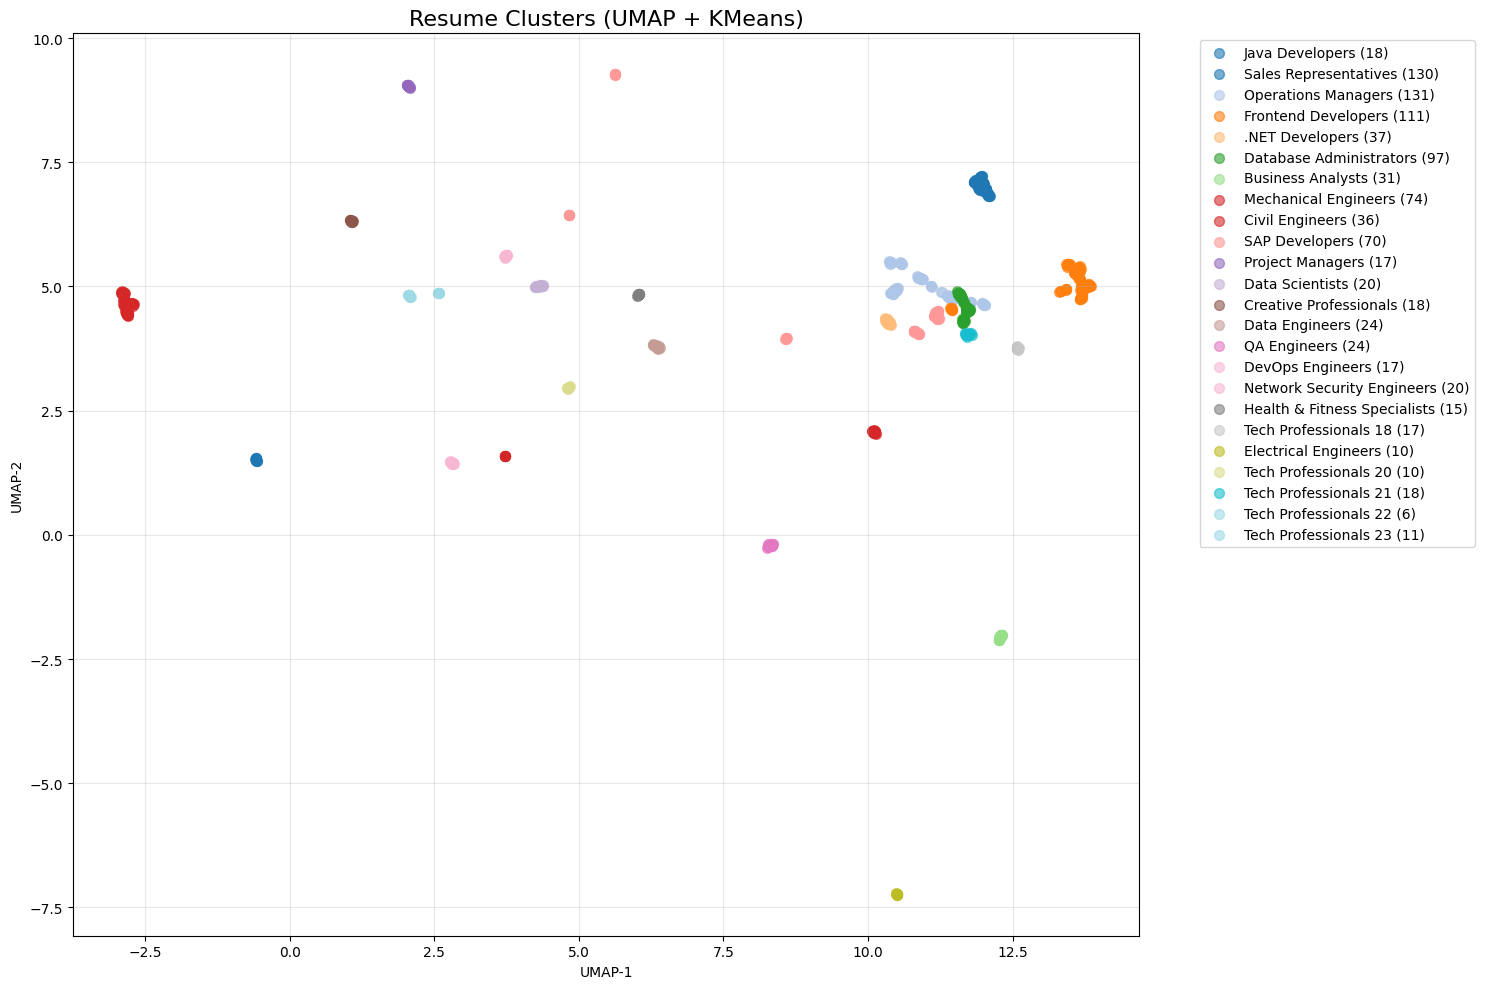

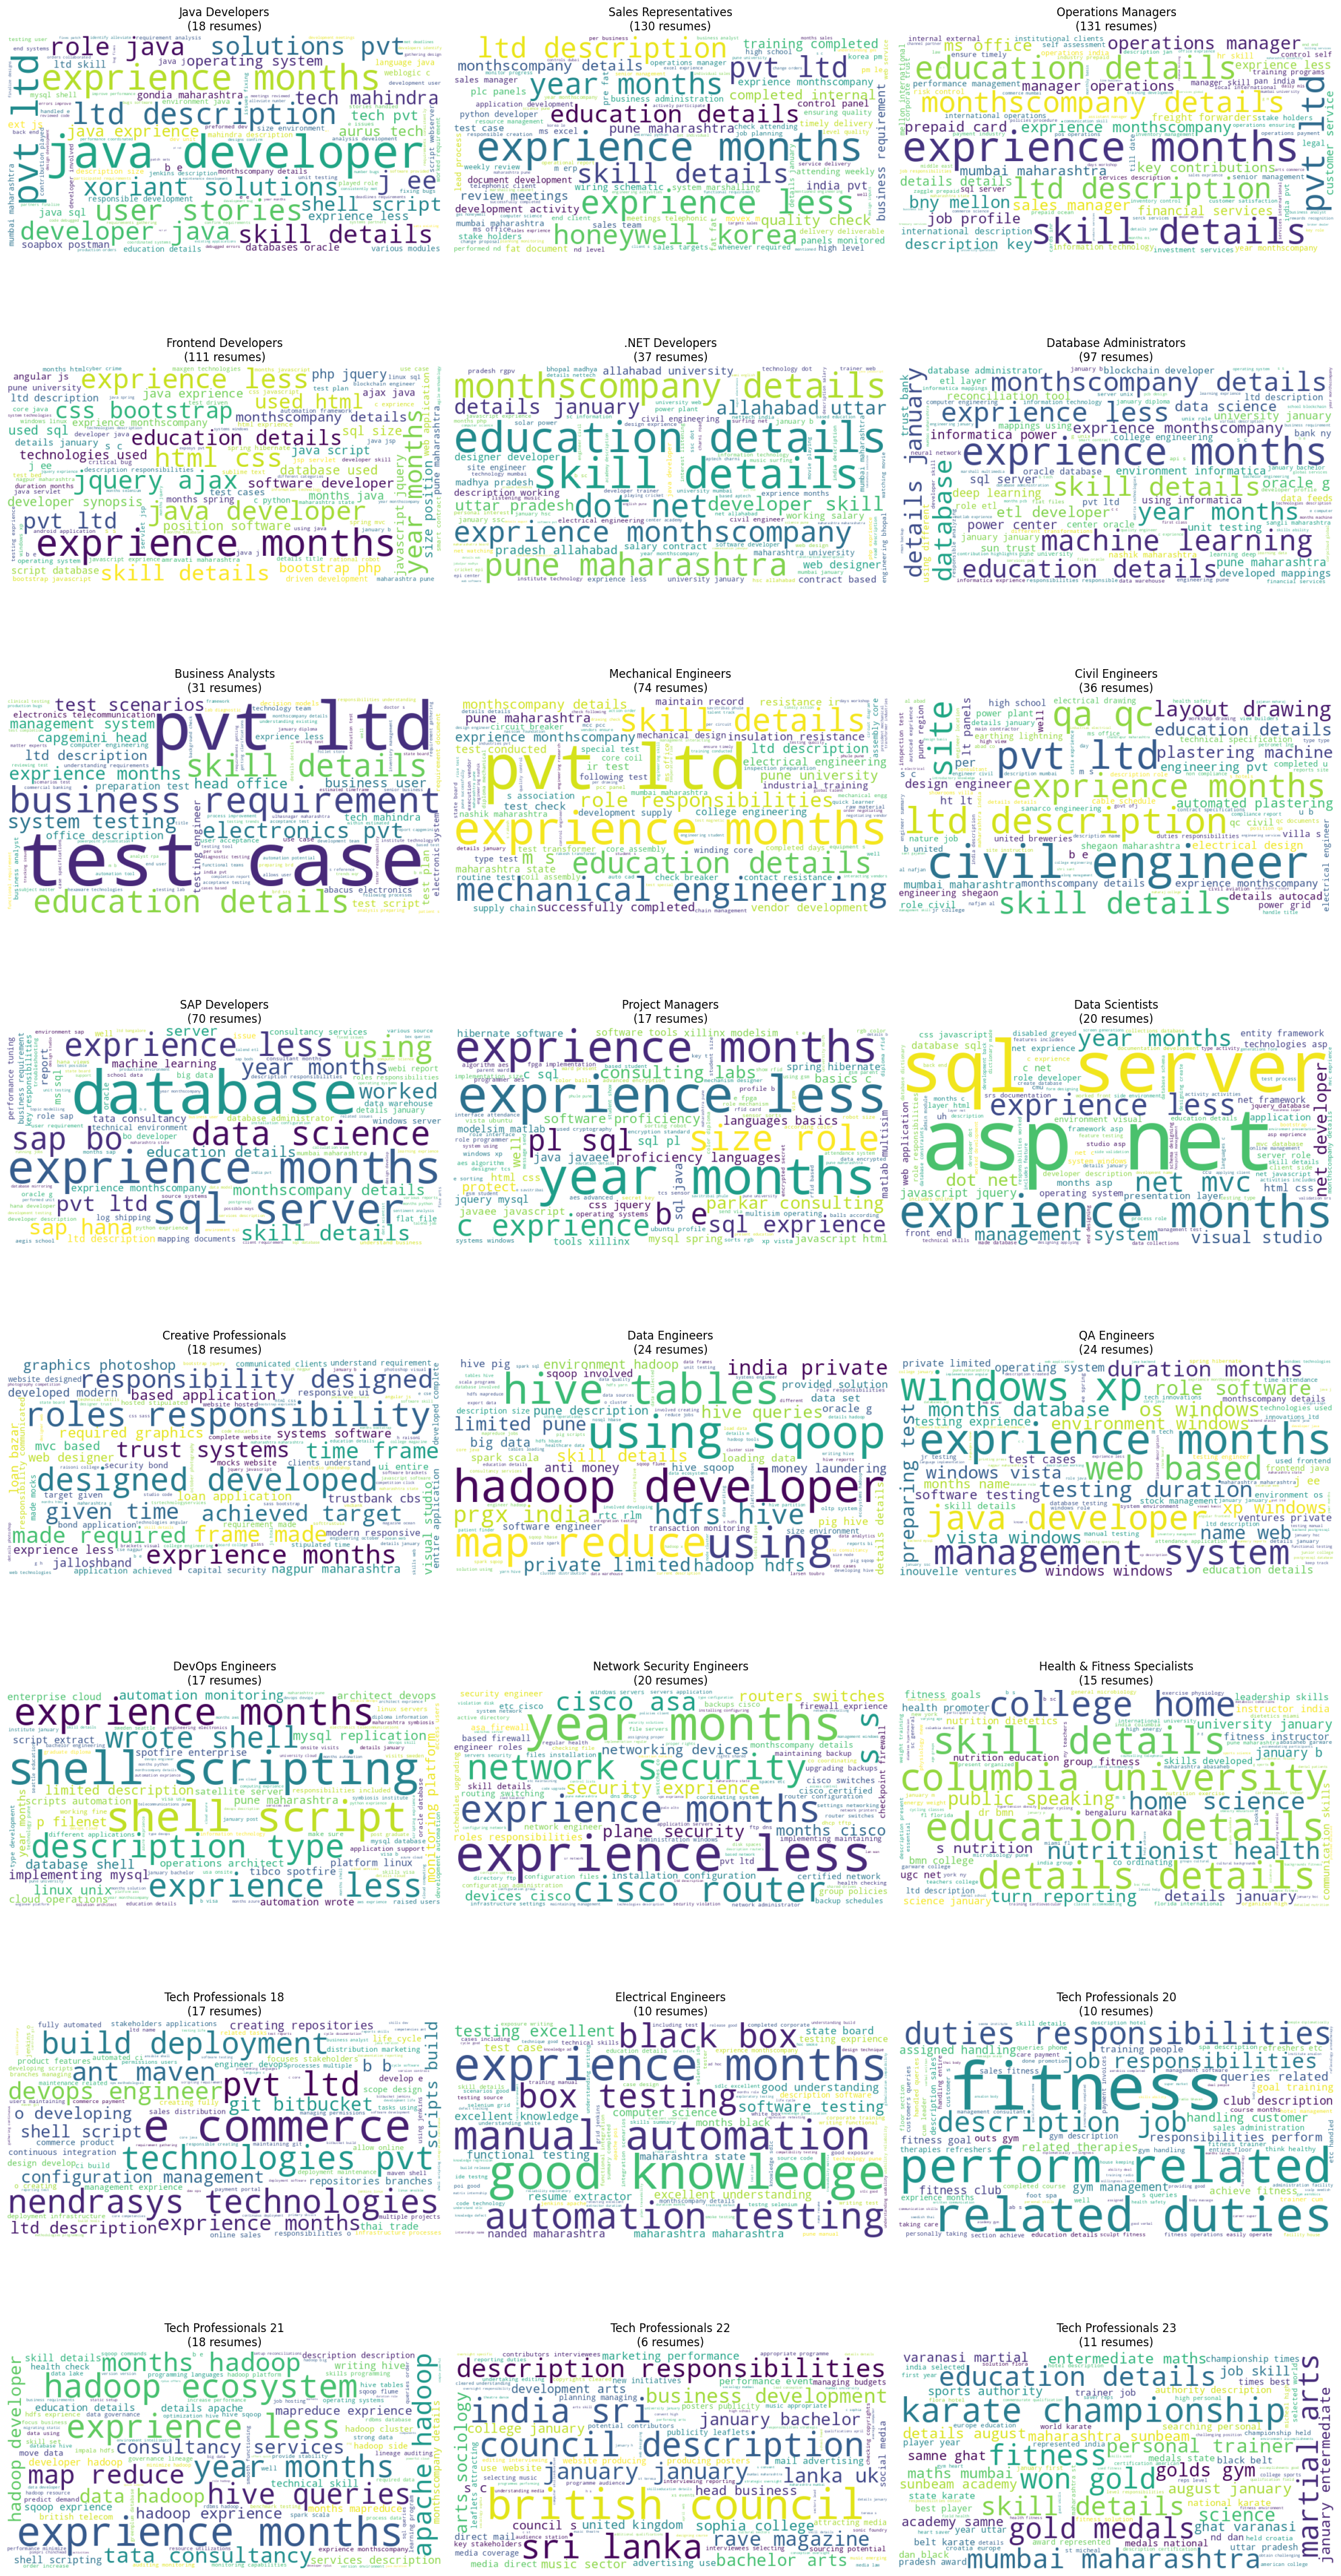

In [17]:
# PCA visualization of UMAP-reduced
plt.figure(figsize=(15, 10))
colors = plt.cm.tab20(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_points = X_umap[df['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[i]], alpha=0.6, s=50, label=f'{cluster_names[i]} ({sum(df["cluster"] == i)})')
plt.title('Resume Clusters (UMAP + KMeans)', fontsize=16)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Wordclouds for each cluster
n_cols = 3
n_rows = (optimal_k + n_cols - 1) // n_cols
plt.figure(figsize=(20, 5 * n_rows))
for i in range(optimal_k):
    cluster_data = df[df['cluster'] == i]
    cluster_text = ' '.join(cluster_data['cleaned_resume'])
    if len(cluster_text) > 0:
        words_to_remove = common_stop_words.union({'experience', 'work', 'years', 'team', 'company', 'project', 'projects'})
        filtered_text = ' '.join([word for word in cluster_text.split() if word not in words_to_remove])
        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              max_words=100,
                              colormap='viridis').generate(filtered_text)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{cluster_names[i]}\n({sum(df["cluster"] == i)} resumes)', fontsize=12)
        plt.axis('off')
plt.tight_layout()
plt.show()


In [18]:
import joblib
import os

save_directory = '/content/drive/MyDrive/DATASETS/resume_clustering_model'
os.makedirs(save_directory, exist_ok=True)

model_components = {
    'kmeans_model': final_kmeans,
    'umap_model': umap_model,
    'scaler': scaler,
    'pca_model': pca,
    'cluster_names': cluster_names,
    'optimal_k': optimal_k,
    'embeddings': X_embeddings
}

model_path = os.path.join(save_directory, 'resume_clustering_model.pkl')
joblib.dump(model_components, model_path)
df.to_csv(os.path.join(save_directory, 'clustered_resumes.csv'), index=False)

print(f"Saved model and clustered dataset to {save_directory}")


Saved model and clustered dataset to /content/drive/MyDrive/DATASETS/resume_clustering_model


# END